In [1]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter



@njit
def calculate_epsilon(T):
    """
    args
        T: number of periods
    returns
        A list of T epsilon values
    """
    epsilon_values = []
    
    for i in range(T):
        theta = -((1/1000000) ** (1/T)) + 1
        epsilon = (1 - theta) ** i
        epsilon_values.append(epsilon)
    
    return epsilon_values

@njit
def demand(p1t,p2t):
    """
    args:
        p1t: price of agent 1
        p2t: price of agent 2
    returns:
        d: demand for given set of prices
    """
    if p1t < p2t:
        d = 1 - p1t
    elif p1t == p2t:
        d = 0.5 * (1 - p1t)
    else:
        d = 0
    return d

@njit
def profit(p1t, p2t):
    """
    args:
        p1t: price of agent 1
        p2t: price of agent 2
    returns:
        profit for agent
    """
    return p1t * demand(p1t, p2t)
 
@njit
def Q_func(p_it_idx, s_t_idx, i, j, t, alpha, delta, p_table, Q_table, prices, s_next) -> float: # p_table contains p and s (opponent price)
    prev_est = Q_table[p_it_idx, s_t_idx]
    s_next_index=np.where(prices == s_next)[0][0] 
    maxed_Q = max(Q_table[:, s_next_index])
    new_est = profit(p_table[i, t], p_table[j, t]) + delta * profit(p_table[i, t], s_next) + delta**2 * maxed_Q
    return (1 - alpha) * prev_est + alpha * new_est

    
@njit
def select_price(j, t, p_table, Q_table, prices, epsilon):
    # Exploration
    if epsilon >= np.random.uniform(0,1):
        return np.random.choice(prices)
    else:
    # Exploitation
        s_t_idx = np.where(prices == p_table[j, t-1])[0][0] # current state (opponent's price)
        maxedQ_idx = np.argmax(Q_table[:, s_t_idx])
        return prices[maxedQ_idx]

        

@njit
def Klein_simulation(alpha, delta, T, price_grid):
    #np.random.seed(3)
    # Initializing values
    epsilon = calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    p = len(price_grid)
    q1 = np.zeros((p, p)) 
    q2 = np.zeros((p, p)) 

    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []
    # Setting prices for players in first 2 periods 
    p_table[i, t] = np.random.choice(price_grid) # firm 1 sets price
    t += 1
    p_table[j, t] = np.random.choice(price_grid) # firm 2 sets price
    p_table[i, t] = p_table[i, t-1]
    t += 1 # now t = 2

    for t in range(t, T):
        p_it_idx = np.where(price_grid == p_table[i, t-2])[0][0]
        s_t_idx =  np.where(price_grid == p_table[j, t-2])[0][0]
        s_next = select_price(i, t, p_table, q2, price_grid, epsilon[t])
        q1[p_it_idx, s_t_idx] = Q_func(p_it_idx, s_t_idx, i,j, t-2, alpha, delta, p_table, q1, price_grid, s_next)
             
        
        p_table[i, t] = select_price(j, t, p_table, q1, price_grid, epsilon[t])
        p_table[j, t] = p_table[j, t-1]

        # Store profits for both firms
        profits[i, t] = profit(p_table[i,t], p_table[j,t])
        profits[j, t] = profit(p_table[j,t], p_table[i,t])

        # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)
        
        # changing agents
        tmp = i
        i = j
        j = tmp
        tmp=q1
        q1=q2
        q2=tmp
        
    return p_table, avg_profs1, avg_profs2

@njit
def Klein_simulation_FD(alpha, delta, T, price_grid):
    #np.random.seed(3)
    # Initializing values
    epsilon = calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    p = len(price_grid)
    q1 = np.zeros((p, p)) 
    q2 = np.zeros((p, p)) 

    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []
    #avg_price = []
    # Setting prices for players in first 2 periods 
    p_table[i, t] = np.random.choice(price_grid) # firm 1 sets price
    t += 1
    p_table[j, t] = np.random.choice(price_grid) # firm 2 sets price
    p_table[i, t] = p_table[i, t-1]
    t += 1 # now t = 2

    for t in range(t, T):
        p_it_idx = np.where(price_grid == p_table[i, t-2])[0][0]
        s_t_idx =  np.where(price_grid == p_table[j, t-2])[0][0]
        s_next = select_price(i, t, p_table, q2, price_grid, epsilon[t])
        q1[p_it_idx, s_t_idx] = Q_func(p_it_idx, s_t_idx, i,j, t-2, alpha, delta, p_table, q1, price_grid, s_next)
             
        if t==400000:
            p_table[i,t] = price_grid[s_t_idx - 1]
            #print(p_table[i,t])
        else:
            p_table[i, t] = select_price(j, t, p_table, q1, price_grid, epsilon[t])
        p_table[j, t] = p_table[j, t-1]
        
        #avg_price_t = (p_table[i,t] + p_table[j, t]) / 2
        #avg_price.append(avg_price_t)
        # Store profits for both firms
        profits[i, t] = profit(p_table[i,t], p_table[j,t])
        profits[j, t] = profit(p_table[j,t], p_table[i,t])

        # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)
        
        # changing agents
        tmp = i
        i = j
        j = tmp
        tmp=q1
        q1=q2
        q2=tmp
        
    return p_table, profits, avg_profs1, avg_profs2#, avg_price

In [2]:
k = np.linspace(0,1,7)
a, b, c = Klein_simulation(0.3, 0.95, 500000, k)


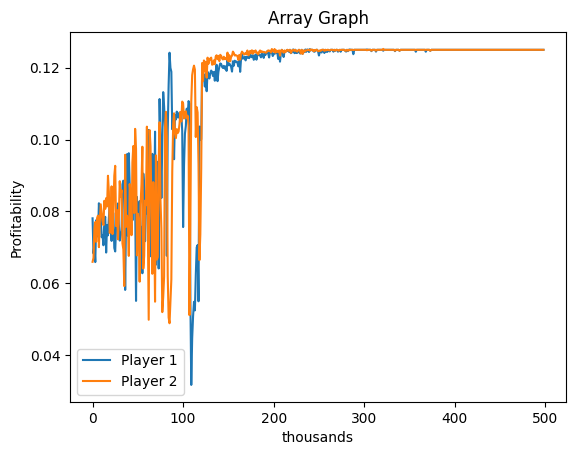

In [3]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, b)
plt.plot(x_values, c)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [4]:

def run_sim(runs, k, method='klein'):
    
    num_calcs=int(500000/1000-1)
    summed_avg_profitabilities = np.zeros(num_calcs)

    for n in range(0, runs):
        p_table, avg_profs1, avg_profs2 = Klein_simulation(0.3, 0.95, 500000, k)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
    
    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, runs)

    fig, axs = plt.subplots(1, 1, figsize=(9,3))
    fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
    axs.set_xlabel("t")
    axs.set_ylabel("profitability")
    xs = np.linspace(0, 500000, num_calcs)
    axs.set_ylim(0.00, 0.125+(0.125*0.05))
    axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
    axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
    axs.plot(xs, avg_avg_profitabilities, color="steelblue", label = "avg. profitability")
    axs.legend()  # Show the legend to display the label of the newly added line
    plt.show()
    return 

# joint profit maximizing

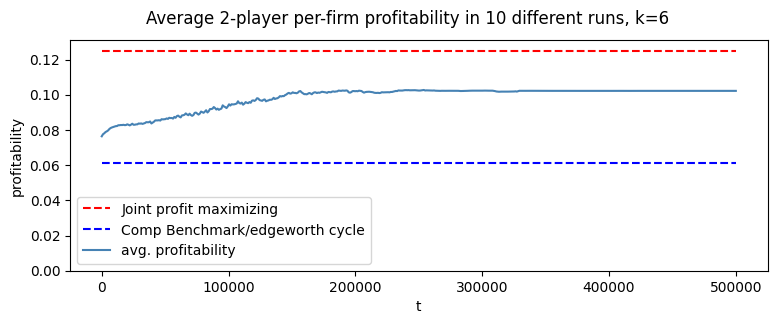

In [5]:
run_sim(100, np.linspace(0,1,13))

## Price cycles

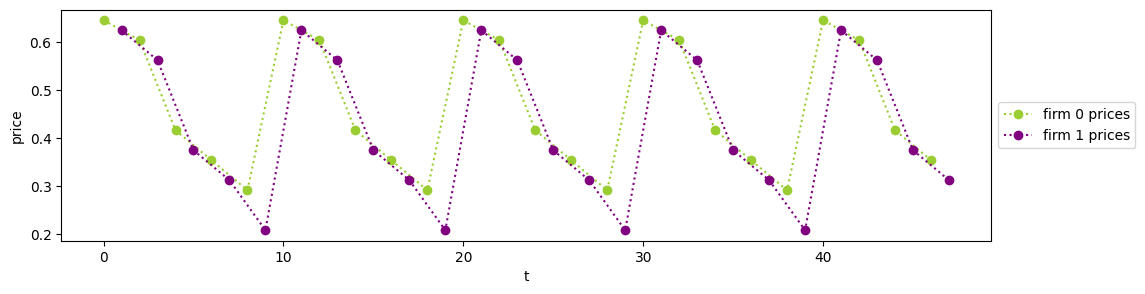

In [6]:
p, b, c = Klein_simulation(0.3, 0.95, 500000, np.linspace(0,1,49))
p1 = p[0,499950:500000]
p2 = p[1,499950:500000]

plt.figure(figsize=(12, 3))
p0s2d = p1[np.arange(0, p1.size, 2)][:-1]
p1s2d = p2[np.arange(1, p2.size, 2)][:-1]

plt.xlabel("t")
plt.ylabel("price")
plt.plot(range(0, 48, 2), p0s2d , label="firm 0 prices", marker="o", color="yellowgreen", linestyle="dotted")
plt.plot(range(1, 48, 2), p1s2d, label="firm 1 prices", marker="o", color="purple", linestyle="dotted")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [29]:
#@njit
def run_simFD(runs, k):
    
    num_calcs=int(500000/1000-1)
    summed_avg_profitabilities = np.zeros(num_calcs)
    A = np.zeros([0,500000])
    B = np.zeros([0,500000])
    C=np.zeros([0,249999])
    D=np.zeros([0,249999])
    counter = 0
    avg_2period_prof1 = []
    avg_2period_prof2 = []
    cap=1
    #for n in range(0, runs):
    while cap<=177:
        p_table,  profits, avg_profs1, avg_profs2 = Klein_simulation_FD(0.3, 0.95, 500000, k)
        var1 = np.var(p_table[0, 398999:399999])
        var2 = np.var(p_table[1, 398999:399999])
        var = np.mean([var1, var2])
        if var < 0.001:
            per_firm_profit = avg_profs1 #np.sum([avg_profs1, avg_profs2], axis=0)/2
            summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
            A = np.vstack([A,p_table[0,:]])
            B = np.vstack([B,p_table[1,:]])
            counter += 1
            avg_2period_prof1 = []
            avg_2period_prof2 = []
            prof1 = profits[0,:]
            prof2 = profits[1,:]
            for i in range(1,len(prof1)-1, 2):
                avg_2period_prof1.append(prof1[i] + prof1[i+1])
                avg_2period_prof2.append(prof2[i] + prof2[i+1])
            #print(len(avg_2period_prof1))
            C = np.vstack([C,avg_2period_prof1])
            D = np.vstack([D,avg_2period_prof2])
            cap+=1
    #print(A)
    #print("Shape of A: ", A.shape)
    sum_avg_prices = np.sum([])
    new = np.zeros([2, 500000])  # Initialize new list with zeros
    for i in range(499998):
        for j in range(counter):
            new[0,i] += A[j, i]
            new[1,i] += B[j, i]
        new[0,i] /= counter  
        new[1,i]/= counter
    
    
    avg_profits=np.zeros([2,250000])

    for i in range(249999):
        for j in range(cap-1):
            avg_profits[0,i] += C[j, i]
            avg_profits[1,i] += D[j, i]
        avg_profits[0,i] /= cap  
        avg_profits[1,i]/= cap

    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, counter)
    #print("Shape of new: ", new.shape)
    #print(counter)
    return new, avg_avg_profitabilities, avg_2period_prof1, avg_2period_prof2, avg_profits

In [45]:
Monk, profits, avg_2pp1,avg2pp2,avg_profitabilities= run_simFD(100,np.linspace(0,1,7))

In [ ]:
len(avg_2pp1)

249999

In [ ]:
MAnkA=Monk[0,::2]
MAnkaB=Monk[1,::2]


## Average Price

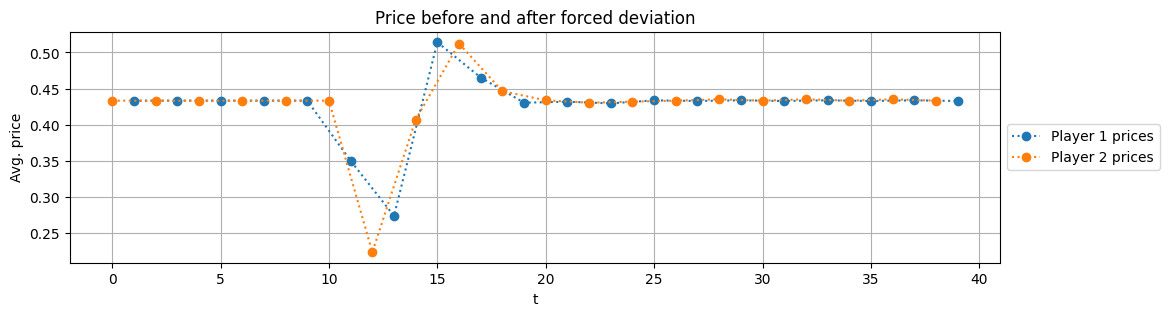

In [ ]:
xvalues = range(len(MAnkA[199995:200015]))
#print(p2)
#print(new)
# Plot the array as a line graph
plt.figure(figsize=(12, 3))
plt.plot(range(1,len(xvalues)*2,2), MAnkA[199995:200015], marker="o", linestyle='dotted')
plt.plot(range(0,len(xvalues)*2,2), MAnkaB[199995:200015], marker="o", linestyle='dotted')
#plt.plot(xvalues, p2, marker="o", linestyle='dotted')

# Add labels and title
plt.grid()
plt.xlabel('t')
plt.ylabel('Avg. price')
plt.title('Price before and after forced deviation')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

## Average Two-Period Profit

In [ ]:
len(avg_profitabilities[1])


250000

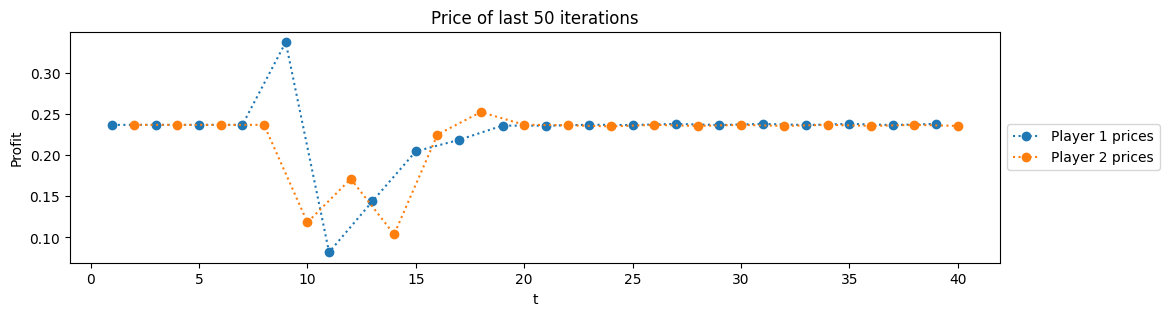

In [ ]:

zoom1 = avg_profitabilities[0,199995:200015]
zoom2 = avg_profitabilities[1,199995:200015]
#print("Last 50 prices for player 1: \n", p1)
#print("Last 50 prices for player 2: \n", p2)


xvalues = range(len(zoom1))
plt.figure(figsize=(12, 3))
# Plot the array as a line graph
plt.plot(range(1,len(xvalues)*2,2), zoom1, marker="o", linestyle='dotted')
plt.plot(range(2,len(xvalues)*2+1,2), zoom2, marker="o", linestyle='dotted')

# Add labels and title
plt.xlabel('t')
plt.ylabel('Profit')
plt.title('Price of last 50 iterations')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

In [ ]:
done = True
while done:
    a, b, c, d = Klein_simulation_FD(0.3, 0.95, 500000, np.linspace(0,1,7))
    if abs(c[498] - d[498]) < 0.001 and abs(c[497] - d[497]) < 0.001 : 
        done = False

In [14]:
len(c)

499

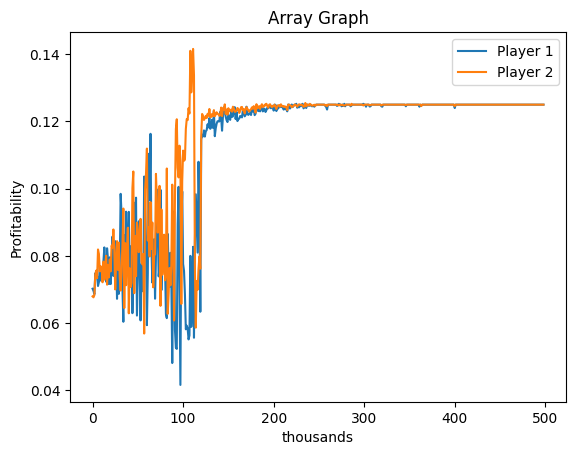

In [15]:
x_values = range(len(c))

# Plot the array as a line graph
plt.plot(x_values, c)
plt.plot(x_values, d)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

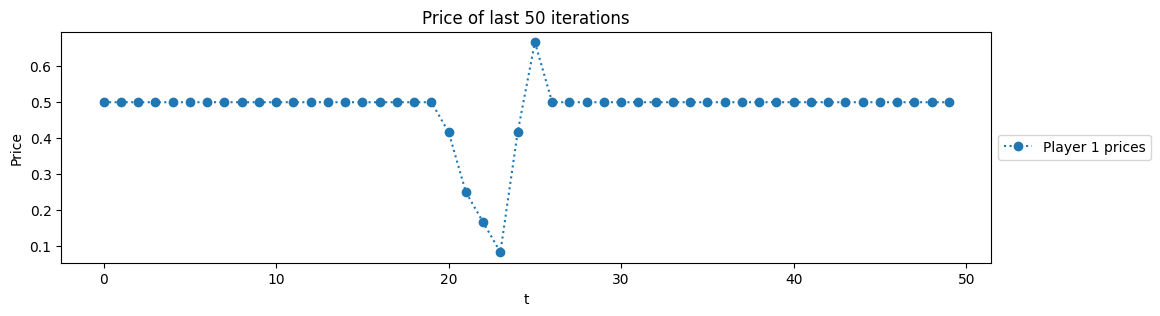

In [16]:
p1 = a[0,399980:400030]
p2 = a[1,399980:400030]

#p1 = p1[1::2]
#p2 = p2[::2]
#print("Last 50 prices for player 1: \n", p1)
#print("Last 50 prices for player 2: \n", p2)
#print(p1)
new=[]
for i in range(len(p1)):
    res=(p1[i]+p2[i])/2
    new.append(res)

xvalues = range(len(new))
plt.figure(figsize=(12, 3))
#print(p2)
#print(new)
# Plot the array as a line graph
plt.plot(xvalues, new, marker="o", linestyle='dotted')
#plt.plot(xvalues, p2, marker="o", linestyle='dotted')

# Add labels and title
plt.xlabel('t')
plt.ylabel('Price')
plt.title('Price of last 50 iterations')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

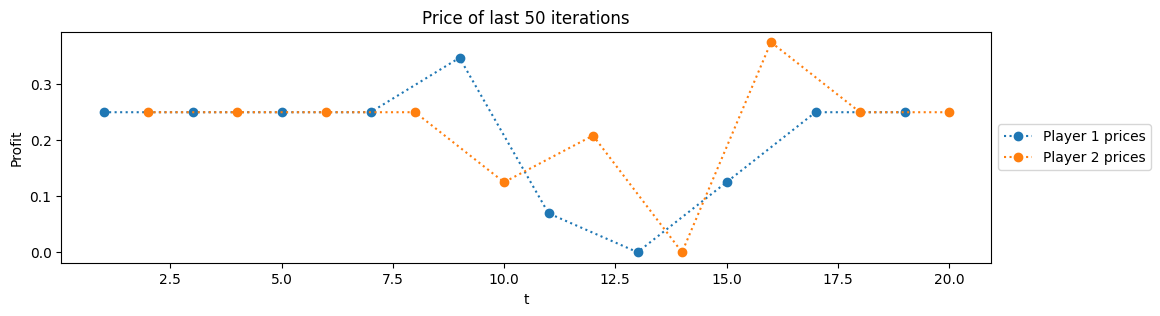

In [17]:
prof1 = b[0,:]
prof2 = b[1,:]

avg_2period_prof1 = []
avg_2period_prof2 = []

for i in range(1,len(prof1)-1, 2):
    avg_2period_prof1.append(prof1[i] + prof1[i+1])
    avg_2period_prof2.append(prof2[i] + prof2[i+1])

zoom1 = avg_2period_prof1[199995:200005]
zoom2 = avg_2period_prof2[199995:200005]
#print("Last 50 prices for player 1: \n", p1)
#print("Last 50 prices for player 2: \n", p2)


xvalues = range(len(zoom1))
plt.figure(figsize=(12, 3))
# Plot the array as a line graph
plt.plot(range(1,len(xvalues)*2,2), zoom1, marker="o", linestyle='dotted')
plt.plot(range(2,len(xvalues)*2+1,2), zoom2, marker="o", linestyle='dotted')

# Add labels and title
plt.xlabel('t')
plt.ylabel('Profit')
plt.title('Price of last 50 iterations')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()